In [1]:
%load_ext autoreload
%autoreload 2

# import core packages
import warnings
warnings.filterwarnings("ignore")
from itertools import combinations
import os

# import semi-core packages
import matplotlib.pyplot as plt

# set global color and font
# plt.rcParams['figure.facecolor'] = 'white' 
# plt.rcParams['font.sans-serif'] = ['Arial']


from matplotlib import colors
%matplotlib inline
plt.style.use('seaborn-poster')
import numpy as np
import pandas as pd
from multiprocessing import Pool

# import open2c libraries
import bioframe
import cooler
import cooltools

from packaging import version
if version.parse(cooltools.__version__) < version.parse('0.5.2'):
    raise AssertionError("tutorial relies on cooltools version 0.5.2 or higher,"+
                         "please check your cooltools version and update to the latest")

# count cpus
num_cpus = os.getenv('SLURM_CPUS_PER_TASK')
if not num_cpus:
    num_cpus = os.cpu_count()
num_cpus = int(num_cpus)

In [2]:
from matplotlib import font_manager

# 加载字体文件
font_path = "/mnt/disk1/6/lxk/private/DNase-C/dimer_paper/figS1/compartment/arial.ttf"  # 替换为你的字体文件路径
font_manager.fontManager.addfont(font_path)

# 设置字体
plt.rcParams["font.family"] = "Arial"
plt.rcParams['font.size'] = 12

In [3]:
resolution = 100
clr_1 = cooler.Cooler(f'/mnt/disk5/1/DNaseC/total/R3D7/regular_file/DMSO4h/DNaseC_R3D7_DMSO4h_UMI_rmdup.mcool::/resolutions/{resolution}')
clr_2 = cooler.Cooler(f'/mnt/disk5/1/DNaseC/total/R3D7/regular_file/dTAG4h/DNaseC_R3D7_dTAG4h_UMI_rmdup.mcool::/resolutions/{resolution}')

In [4]:
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
# create a view with chromosome arms using chromosome sizes and definition of centromeres
hg38_arms = bioframe.make_chromarms(hg38_chromsizes,  hg38_cens)

# select only those chromosomes available in cooler
hg38_arms = hg38_arms[hg38_arms.chrom.isin(clr_1.chromnames)].reset_index(drop=True)
hg38_arms = hg38_arms[hg38_arms['chrom']!='chrY']
hg38_arms

,chrom,start,end,name
0,chr1,0,123479591,chr1_p
1,chr1,123479591,248956422,chr1_q
2,chr2,0,93139351,chr2_p
3,chr2,93139351,242193529,chr2_q
4,chr3,0,92214016,chr3_p
5,chr3,92214016,198295559,chr3_q
6,chr4,0,50728006,chr4_p
7,chr4,50728006,190214555,chr4_q
8,chr5,0,48272853,chr5_p
9,chr5,48272853,181538259,chr5_q


In [5]:
cvd_smooth_agg_1 = cooltools.expected_cis(
    clr=clr_1,
    view_df=hg38_arms,
    ignore_diags=0,
    smooth=True,
    aggregate_smoothed=True,
    smooth_sigma=0.1,
    nproc=num_cpus
)

cvd_smooth_agg_2 = cooltools.expected_cis(
    clr=clr_2,
    view_df=hg38_arms,
    ignore_diags=0,
    smooth=True,
    aggregate_smoothed=True,
    smooth_sigma=0.1,
    nproc=num_cpus
)

In [6]:
display(cvd_smooth_agg_1.head(4))

,region1,region2,dist,n_valid,count.sum,balanced.sum,count.avg,balanced.avg,balanced.avg.smoothed,balanced.avg.smoothed.agg
0,chr1_p,chr1_p,0,1125367,259136.0,4914.773511,0.230268,0.004367,NaN,NaN
1,chr1_p,chr1_p,1,1095681,701277.0,12565.533524,0.640038,0.011468,0.011419,0.011114
2,chr1_p,chr1_p,2,1089428,446689.0,7471.763764,0.410022,0.006858,0.006533,0.006470
3,chr1_p,chr1_p,3,1087440,317735.0,5286.604670,0.292186,0.004862,0.004911,0.004904


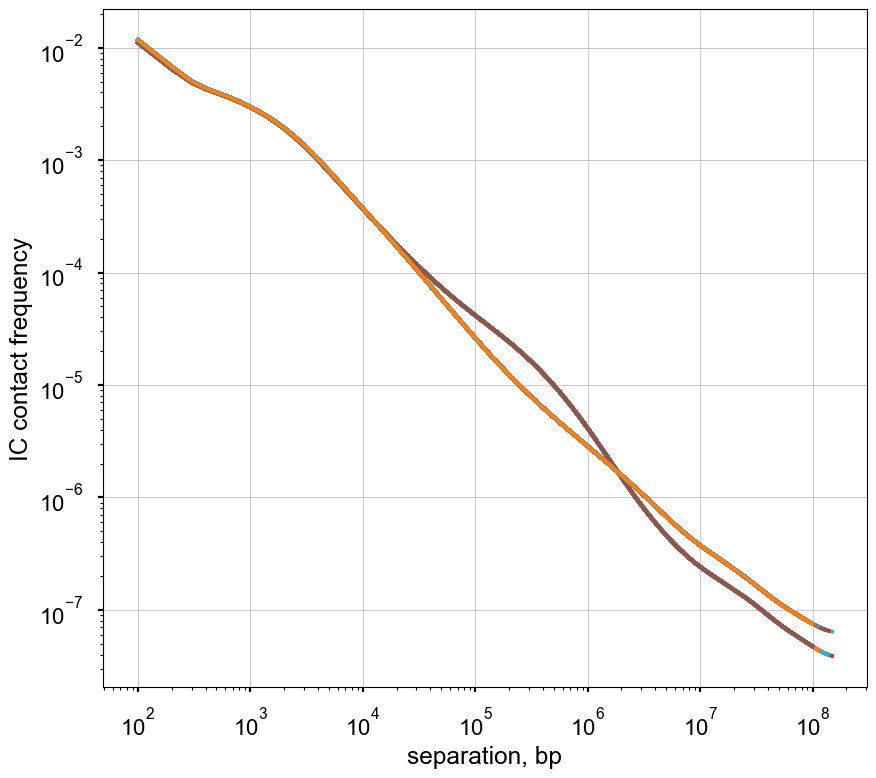

In [7]:
cvd_smooth_agg_1['balanced.avg.smoothed.agg'].loc[cvd_smooth_agg_1['dist'] < 1] = np.nan
cvd_smooth_agg_2['balanced.avg.smoothed.agg'].loc[cvd_smooth_agg_2['dist'] < 1] = np.nan

f, ax = plt.subplots(1,1)

for region in hg38_arms['name']:
    ax.loglog(
        cvd_smooth_agg_1['dist'].loc[cvd_smooth_agg_1['region1']==region]*resolution,
        cvd_smooth_agg_1['balanced.avg.smoothed.agg'].loc[cvd_smooth_agg_1['region1']==region],
#         label=region,
    )
    ax.set(
        xlabel='separation, bp',
        ylabel='IC contact frequency')
    ax.set_aspect(1.0)
    ax.grid(lw=0.5)
#     ax.legend()
    

    
for region in hg38_arms['name']:
    ax.loglog(
        cvd_smooth_agg_2['dist'].loc[cvd_smooth_agg_2['region1']==region]*resolution,
        cvd_smooth_agg_2['balanced.avg.smoothed.agg'].loc[cvd_smooth_agg_2['region1']==region],
    )
    ax.set(
        xlabel='separation, bp',
        ylabel='IC contact frequency')
    ax.set_aspect(1.0)
    ax.grid(lw=0.5)

In [8]:
# Just take a single value for each genomic separation
cvd_merged_1 = cvd_smooth_agg_1.drop_duplicates(subset=['dist'])[['dist', 'balanced.avg.smoothed.agg']]

cvd_merged_2 = cvd_smooth_agg_2.drop_duplicates(subset=['dist'])[['dist', 'balanced.avg.smoothed.agg']]

In [9]:
# Calculate derivative in log-log space
der_1 = np.gradient(np.log(cvd_merged_1['balanced.avg.smoothed.agg']),
                  np.log(cvd_merged_1['dist']*resolution))

der_2 = np.gradient(np.log(cvd_merged_2['balanced.avg.smoothed.agg']),
                  np.log(cvd_merged_2['dist']*resolution))

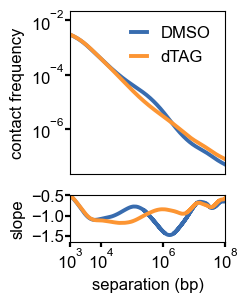

In [10]:
f, axs = plt.subplots(
    figsize=(2,3),
#     facecolor='white',
    nrows=2,
    gridspec_kw={'height_ratios':[3.5,1]},
    sharex=True
)


ax = axs[0]
ax.loglog(
    cvd_merged_1['dist']*resolution,
    cvd_merged_1['balanced.avg.smoothed.agg'],
#     '-',
    label='DMSO',
    color='#386CAF'
)

ax.loglog(
    cvd_merged_2['dist']*resolution,
    cvd_merged_2['balanced.avg.smoothed.agg'],
#     '-',
    label='dTAG',
    color='#fc9533'
)


ax.set(
    yticks=(1e-2,1e-4,1e-6),
    xlim=(1e3,1e8),
)
ax.set_ylabel('contact frequency', fontsize=12)

# 设置刻度标签的字体大小
ax.tick_params(axis='both', labelsize=12)
ax.legend(frameon=False, handlelength=1, fontsize=12)
ax.xaxis.set_visible(False)

# 这不会直接调整标签与轴之间的距离，但可以用于调整刻度线的位置
ax.tick_params(axis='both', which='major', pad=1)

# ax.set_aspect(1.0)
ax.grid(b=False,
#         lw=0.5
       )

# ax.patch.set_alpha(0.0)

ax = axs[1]
ax.semilogx(
    cvd_merged_1['dist']*resolution,
    der_1,
    alpha=1,
    color='#386CAF'
)

ax.semilogx(
    cvd_merged_2['dist']*resolution,
    der_2,
    alpha=1,
    color='#fc9533'
)

ax.set(
    xticks=(1e3, 1e4, 1e6, 1e8),
    ylim=(-1.65,-0.5),
)
ax.set_xlabel('separation (bp)', fontsize=12)
ax.set_ylabel('slope', fontsize=12)

# 设置刻度标签的字体大小
ax.tick_params(axis='both', labelsize=12)
# 这不会直接调整标签与轴之间的距离，但可以用于调整刻度线的位置
ax.tick_params(axis='both', which='major', pad=1)

ax.grid(
        b=False,
#         lw=0.5
       )

# ax.patch.set_alpha(0.0)

In [11]:
# f.savefig('decay.pdf')

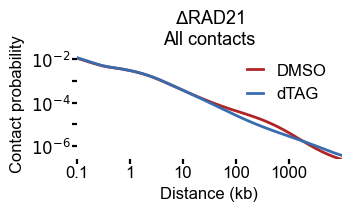

In [19]:
from matplotlib import font_manager

# 加载字体文件
font_path = "/mnt/disk1/6/lxk/private/DNase-C/dimer_paper/figS1/compartment/arial.ttf"  # 替换为你的字体文件路径
font_manager.fontManager.addfont(font_path)

# 设置字体
plt.rcParams["font.family"] = "Arial"
plt.rcParams['font.size'] = 12


f, ax = plt.subplots(
    figsize=(3.4,2.0),
#     facecolor='white',
#     nrows=1,
#     gridspec_kw={'height_ratios':[3.5,1]},
#     sharex=True
    constrained_layout=True
)


ax.loglog(
    cvd_merged_1['dist']*resolution,
    cvd_merged_1['balanced.avg.smoothed.agg'],
#     '-',
    label='DMSO',
    color='#b12425',
    linewidth=2
)

ax.loglog(
    cvd_merged_2['dist']*resolution,
    cvd_merged_2['balanced.avg.smoothed.agg'],
#     '-',
    label='dTAG',
    color='#386CAF',
    linewidth=2
)

ax.set(
    xlim=(1e2,1e7),
    xticks=(1e2, 1e3, 1e4, 1e5, 1e6),
    xticklabels=(0.1, 1, 10, 100, 1000),
    
#     ylim=(1e-7,1e-1),
    ylim=(10**(-6.6), 10**(-1.5)),
    yticks=(1e-2,1e-3,1e-4,1e-5,1e-6),
    yticklabels=(r'$10^{-2}$','',r'$10^{-4}$','',r'$10^{-6}$')
)
ax.set_ylabel('Contact probability', fontsize=12)
ax.set_xlabel('Distance (kb)', fontsize=12)
ax.set_title(r'$\Delta$RAD21' + '\n' + 'All contacts',
             fontsize=13,      # 字体大小
             fontweight='bold', # 字体粗细
             pad=0,           # 标题与图形的距离
             loc='center',     # 位置：'left', 'center', 'right'
             color='black'     # 颜色
            )

# 设置刻度标签的字体大小
ax.tick_params(axis='both', labelsize=12)
ax.legend(frameon=False, handlelength=1, fontsize=12)
# ax.xaxis.set_visible(False)

# 这不会直接调整标签与轴之间的距离，但可以用于调整刻度线的位置
ax.tick_params(axis='both', which='major', pad=1)


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

In [20]:
f.savefig('decay_R2.pdf', dpi=300, bbox_inches='tight', pad_inches=0.05)